In [ ]:
# Install dependencies
!pip install tensorflow scikit-learn pandas numpy matplotlib --quiet

**Dataset Collection**

In [ ]:
import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

OUT = "synthetic_ayursutra"
os.makedirs(OUT, exist_ok=True)

# Updated parameters
n_patients = 1000
days = 180

therapy_types = ['Abhyanga', 'Basti', 'Shirodhara', 'Nasya']

records = []
ages = np.random.randint(18, 70, n_patients)
doshas = np.random.choice(['Vata', 'Pitta', 'Kapha'], n_patients, p=[0.35, 0.35, 0.3])

for pid in range(n_patients):
    archetype = np.random.choice(['A', 'B', 'C'], p=[0.4, 0.35, 0.25])
    base_hr = 60 + (ages[pid] - 30) * 0.3 + np.random.randn() * 3
    base_bp = 110 + (ages[pid] - 30) * 0.5 + np.random.randn() * 4
    for d in range(days):
        therapy = np.random.choice(therapy_types, p=[0.4, 0.25, 0.2, 0.15])
        hr = base_hr + np.sin(d / 3.0) * 2 + np.random.randn() * 2 - (0.3 if therapy == 'Abhyanga' else 0)
        bp = base_bp + np.cos(d / 5.0) * 3 + np.random.randn() * 3 - (0.8 if therapy == 'Basti' else 0)
        sleep = np.clip(0.6 + (0.1 if archetype == 'A' else (-0.05 if archetype == 'C' else 0)) + np.random.randn() * 0.05, 0.2, 1.0)
        symptom = np.clip(
            4 + (0 if archetype == 'B' else (-1 if archetype == 'A' else 1)) + np.random.randn() * 1.0 -
            (0.6 if therapy in ['Abhyanga', 'Shirodhara'] else 0),
            0, 10
        )
        wellness = np.clip((sleep * 4) + (10 - symptom) * 0.6 + (80 - hr) * 0.05 + np.random.randn() * 0.3, 0, 10)
        records.append({
            'patient_id': pid,
            'day': d,
            'age': ages[pid],
            'dosha': doshas[pid],
            'archetype': archetype,
            'therapy': therapy,
            'heart_rate': hr,
            'bp_systolic': bp,
            'sleep_quality': sleep,
            'symptom_score': symptom,
            'wellness_score': wellness
        })

df = pd.DataFrame(records)
print("✅ Base dataset created with shape:", df.shape)

# Save dataset
df.to_csv(os.path.join(OUT, "daily_records_impure.csv"), index=False)
print("✅ Final impure dataset saved:", os.path.join(OUT, "daily_records_impure.csv"))
print("Final dataset shape:", df.shape)

✅ Base dataset created with shape: (180000, 11)
✅ Final impure dataset saved: synthetic_ayursutra/daily_records_impure.csv
Final dataset shape: (180000, 11)


**Data Preprocessing**

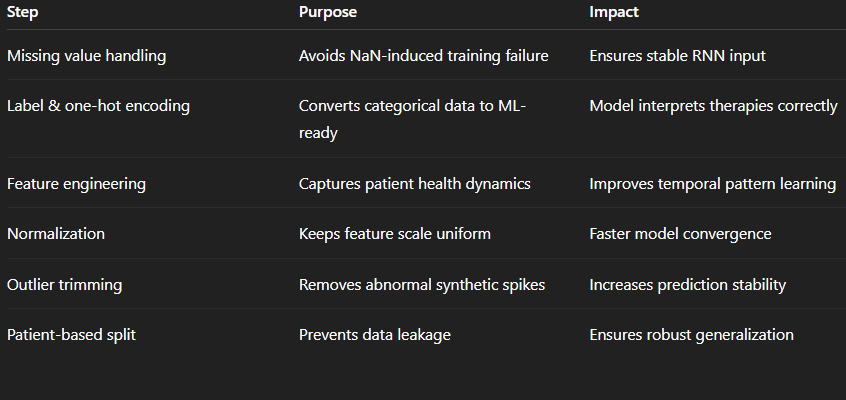

In [ ]:
# --- Preprocessing Pipeline for AyurSutra Synthetic Dataset ---

import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# Load dataset
df = pd.read_csv("/content/synthetic_ayursutra/daily_records_impure.csv")

print("🔹 Initial shape:", df.shape)
print("🔹 Missing values:\n", df.isnull().sum())

# 1️⃣ Handle Missing Values (synthetic usually clean, but real-world ready)
df.fillna(method='ffill', inplace=True)

# 2️⃣ Encode Categorical Features
# Encode 'dosha' and 'therapy' into numeric features
le_dosha = LabelEncoder()
df['dosha_encoded'] = le_dosha.fit_transform(df['dosha'])

therapy_ohe = pd.get_dummies(df['therapy'], prefix='therapy')
df = pd.concat([df, therapy_ohe], axis=1)

# 3️⃣ Feature Engineering
# Add trend-based features (helpful for RNN temporal learning)
df['hr_change'] = df.groupby('patient_id')['heart_rate'].diff().fillna(0)
df['bp_change'] = df.groupby('patient_id')['bp_systolic'].diff().fillna(0)
df['symptom_trend'] = df.groupby('patient_id')['symptom_score'].diff().fillna(0)

# Normalize numerical columns
num_cols = ['heart_rate', 'bp_systolic', 'sleep_quality', 'symptom_score',
            'hr_change', 'bp_change', 'symptom_trend']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# 4️⃣ Outlier Detection & Smoothing (use z-score cutoff)
from scipy.stats import zscore
z_scores = np.abs(zscore(df[num_cols]))
df = df[(z_scores < 3).all(axis=1)]  # remove extreme outliers

# 5️⃣ Train-Test Split Preparation
# Ensure each patient’s records are in only one set to avoid leakage
unique_patients = df['patient_id'].unique()
np.random.shuffle(unique_patients)
split = int(0.8 * len(unique_patients))
train_ids, test_ids = unique_patients[:split], unique_patients[split:]
train_df = df[df['patient_id'].isin(train_ids)]
test_df = df[df['patient_id'].isin(test_ids)]

print(f"✅ Preprocessing complete: Train={train_df.shape}, Test={test_df.shape}")
train_df.head()

🔹 Initial shape: (180000, 11)
🔹 Missing values:
 patient_id        0
day               0
age               0
dosha             0
archetype         0
therapy           0
heart_rate        0
bp_systolic       0
sleep_quality     0
symptom_score     0
wellness_score    0
dtype: int64


/tmp/ipython-input-2323392346.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


✅ Preprocessing complete: Train=(142484, 19), Test=(35653, 19)


,patient_id,day,age,dosha,archetype,therapy,heart_rate,bp_systolic,sleep_quality,symptom_score,wellness_score,dosha_encoded,therapy_Abhyanga,therapy_Basti,therapy_Nasya,therapy_Shirodhara,hr_change,bp_change,symptom_trend
0,0,0,56,Pitta,A,Shirodhara,1.434498,1.477796,1.064595,-1.093770,7.991060,1,False,False,False,True,0.000305,0.005105,0.000120
1,0,1,56,Pitta,A,Shirodhara,0.722103,1.002775,0.382264,-1.396225,8.114537,1,False,False,False,True,-1.496273,-1.032202,-0.269242
2,0,2,56,Pitta,A,Nasya,0.259523,1.489236,0.247525,-2.045725,8.908469,1,False,False,True,False,-0.971471,1.067393,-0.578316
4,0,4,56,Pitta,A,Nasya,1.014103,1.223134,1.523160,-0.620124,7.931871,1,False,False,True,False,-1.591247,-0.329625,0.064581
5,0,5,56,Pitta,A,Shirodhara,1.101579,1.042377,0.794384,-1.766380,8.386912,1,False,False,False,True,0.184072,-0.389614,-1.020720


In [ ]:
!pip install torch torchvision torchaudio scikit-learn pandas numpy matplotlib tqdm

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import random

In [ ]:
# Configuration
DATA_PATH = "/content/daily_records_impure.csv"   # change if needed
SEQ_LEN = 30
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 35
PATIENCE = 6

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


Using device: cuda


In [ ]:
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(180000, 11)


,,day,age,dosha,archetype,therapy,heart_rate,bp_systolic,sleep_quality,symptom_score,wellness_score
0,0,0,56,Pitta,A,Shirodhara,72.657649,130.300266,0.709602,2.090884,7.991060
1,0,1,56,Pitta,A,Shirodhara,68.368440,125.848729,0.655513,1.695712,8.114537
2,0,2,56,Pitta,A,Nasya,65.583319,130.407470,0.644832,0.847109,8.908469
3,0,3,56,Pitta,A,Nasya,74.687931,129.350236,0.699922,2.615158,7.635390
4,0,4,56,Pitta,A,Nasya,70.126525,127.913764,0.745954,2.709725,7.931871


In [ ]:
df.columns.tolist()

['  ',
 'day',
 'age',
 'dosha',
 'archetype',
 'therapy',
 'heart_rate',
 'bp_systolic',
 'sleep_quality',
 'symptom_score',
 'wellness_score']

In [ ]:
# Clean unwanted column
if '  ' in df.columns:
    df = df.drop(columns=['  '])

REG_TARGET = "wellness_score"
CLASS_TARGET = "archetype"

print("Available columns:", df.columns.tolist())
print("Regression target:", REG_TARGET)
print("Classification target:", CLASS_TARGET)

# Label encode classifier
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["cls"] = le.fit_transform(df[CLASS_TARGET])
n_classes = len(le.classes_)
print("Classes:", le.classes_)

# Identify numeric input features
exclude_cols = {REG_TARGET, CLASS_TARGET, "cls"}
num_cols = [c for c in df.columns if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])]
print("Numeric features used:", num_cols)


Available columns: ['day', 'age', 'dosha', 'archetype', 'therapy', 'heart_rate', 'bp_systolic', 'sleep_quality', 'symptom_score', 'wellness_score']
Regression target: wellness_score
Classification target: archetype
Classes: ['A' 'B' 'C']
Numeric features used: ['day', 'age', 'heart_rate', 'bp_systolic', 'sleep_quality', 'symptom_score']


In [ ]:
X_seq, y_reg, y_cls = [], [], []

for i in range(SEQ_LEN, len(df)):
    window = df.loc[i-SEQ_LEN:i-1, num_cols].values.astype(np.float32)
    X_seq.append(window)
    y_reg.append(df.loc[i, REG_TARGET])
    y_cls.append(df.loc[i, "cls"])

X_seq = np.array(X_seq)
y_reg = np.array(y_reg).astype(np.float32)
y_cls = np.array(y_cls).astype(int)

print("X shape:", X_seq.shape)


X shape: (179970, 30, 6)


In [ ]:
split = int(0.8 * len(X_seq))

X_train, X_test = X_seq[:split], X_seq[split:]
y_reg_train, y_reg_test = y_reg[:split], y_reg[split:]
y_cls_train, y_cls_test = y_cls[:split], y_cls[split:]

# scale features using train only
scaler = StandardScaler()
X_train_2d = X_train.reshape(-1, len(num_cols))
X_test_2d = X_test.reshape(-1, len(num_cols))

scaler.fit(X_train_2d)
X_train_s = scaler.transform(X_train_2d).reshape(X_train.shape)
X_test_s = scaler.transform(X_test_2d).reshape(X_test.shape)


In [ ]:
class WellnessDataset(Dataset):
    def __init__(self, X, r, c):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_reg = torch.tensor(r, dtype=torch.float32)
        self.y_cls = torch.tensor(c, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y_reg[idx], self.y_cls[idx]

train_ds = WellnessDataset(X_train_s, y_reg_train, y_cls_train)
test_ds = WellnessDataset(X_test_s, y_reg_test, y_cls_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
class WellnessModel(nn.Module):
    def __init__(self, n_feats, hidden=64, n_classes=3):
        super().__init__()
        self.lstm = nn.LSTM(n_feats, hidden, batch_first=True)
        self.reg_head = nn.Linear(hidden, 1)
        self.cls_head = nn.Linear(hidden, n_classes)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        h = h[-1]
        reg_out = self.reg_head(h)
        cls_out = self.cls_head(h)
        return reg_out.squeeze(-1), cls_out

model = WellnessModel(len(num_cols), hidden=64, n_classes=n_classes).to(DEVICE)
opt = optim.Adam(model.parameters(), lr=LR)
loss_reg = nn.MSELoss()
loss_cls = nn.CrossEntropyLoss()


In [ ]:
best_loss = float("inf")
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for Xb, rb, cb in train_loader:
        Xb, rb, cb = Xb.to(DEVICE), rb.to(DEVICE), cb.to(DEVICE)

        opt.zero_grad()
        pred_r, pred_c = model(Xb)

        l1 = loss_reg(pred_r, rb)
        l2 = loss_cls(pred_c, cb)
        loss = l1 + l2

        loss.backward()
        opt.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        print("Early stopping triggered")
        break


Epoch 1/35 | Loss: 1.7974
Epoch 2/35 | Loss: 0.6043
Epoch 3/35 | Loss: 0.5871
Epoch 4/35 | Loss: 0.5810
Epoch 5/35 | Loss: 0.5761
Epoch 6/35 | Loss: 0.5725
Epoch 7/35 | Loss: 0.5702
Epoch 8/35 | Loss: 0.5698
Epoch 9/35 | Loss: 0.5678
Epoch 10/35 | Loss: 0.5667
Epoch 11/35 | Loss: 0.5666
Epoch 12/35 | Loss: 0.5662
Epoch 13/35 | Loss: 0.5641
Epoch 14/35 | Loss: 0.5644
Epoch 15/35 | Loss: 0.5620
Epoch 16/35 | Loss: 0.5631
Epoch 17/35 | Loss: 0.5617
Epoch 18/35 | Loss: 0.5610
Epoch 19/35 | Loss: 0.5616
Epoch 20/35 | Loss: 0.5598
Epoch 21/35 | Loss: 0.5600
Epoch 22/35 | Loss: 0.5590
Epoch 23/35 | Loss: 0.5588
Epoch 24/35 | Loss: 0.5578
Epoch 25/35 | Loss: 0.5584
Epoch 26/35 | Loss: 0.5568
Epoch 27/35 | Loss: 0.5564
Epoch 28/35 | Loss: 0.5569
Epoch 29/35 | Loss: 0.5560
Epoch 30/35 | Loss: 0.5549
Epoch 31/35 | Loss: 0.5542
Epoch 32/35 | Loss: 0.5550
Epoch 33/35 | Loss: 0.5544
Epoch 34/35 | Loss: 0.5537
Epoch 35/35 | Loss: 0.5536


In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


WellnessModel(
  (lstm): LSTM(6, 64, batch_first=True)
  (reg_head): Linear(in_features=64, out_features=1, bias=True)
  (cls_head): Linear(in_features=64, out_features=3, bias=True)
)

In [ ]:
pred_reg_list = []
true_reg_list = []
pred_cls_list = []
true_cls_list = []

with torch.no_grad():
    for Xb, rb, cb in test_loader:
        Xb = Xb.to(DEVICE)
        pr, pc = model(Xb)

        pred_reg_list.extend(pr.cpu().numpy())
        true_reg_list.extend(rb.numpy())

        pred_cls_list.extend(pc.argmax(dim=1).cpu().numpy())
        true_cls_list.extend(cb.numpy())

pred_reg_list = np.array(pred_reg_list)
true_reg_list = np.array(true_reg_list)


In [ ]:
mae = mean_absolute_error(true_reg_list, pred_reg_list)
rmse = mean_squared_error(true_reg_list, pred_reg_list) ** 0.5
r2 = r2_score(true_reg_list, pred_reg_list)

print("REGRESSION METRICS")
print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


REGRESSION METRICS
MAE : 0.5886497497558594
RMSE: 0.7367453771574949
R²  : 0.5189017057418823


In [ ]:
acc = accuracy_score(true_cls_list, pred_cls_list)
f1 = f1_score(true_cls_list, pred_cls_list, average='weighted')

print("\nCLASSIFICATION METRICS")
print("Accuracy:", acc)
print("F1 Score:", f1)
print("\nClassification Report:")
print(classification_report(true_cls_list, pred_cls_list, target_names=le.classes_))



CLASSIFICATION METRICS
Accuracy: 0.9920264488525865
F1 Score: 0.9920268508052259

Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.99      1.00     14220
           B       0.99      0.99      0.99     12240
           C       0.99      0.99      0.99      9534

    accuracy                           0.99     35994
   macro avg       0.99      0.99      0.99     35994
weighted avg       0.99      0.99      0.99     35994



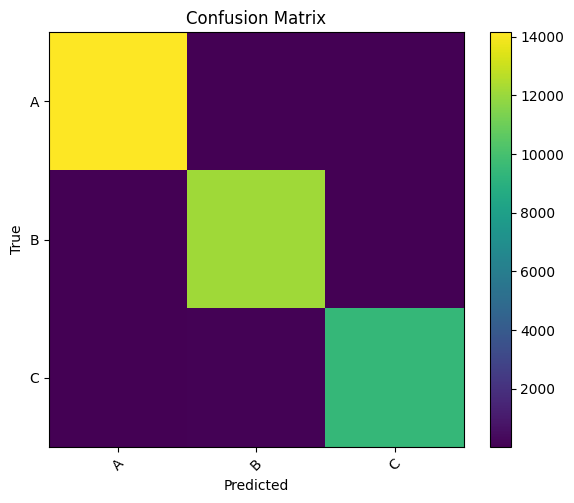

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(true_cls_list, pred_cls_list)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


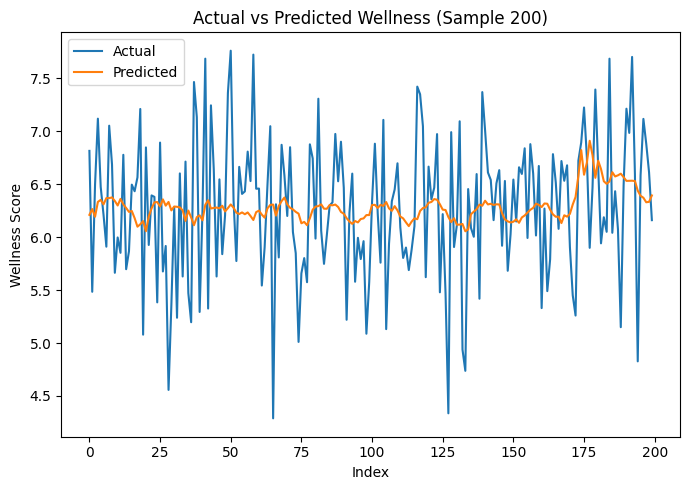

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(true_reg_list[:200], label="Actual")      # first 200 for visibility
plt.plot(pred_reg_list[:200], label="Predicted")
plt.title("Actual vs Predicted Wellness (Sample 200)")
plt.xlabel("Index")
plt.ylabel("Wellness Score")
plt.legend()
plt.tight_layout()
plt.show()


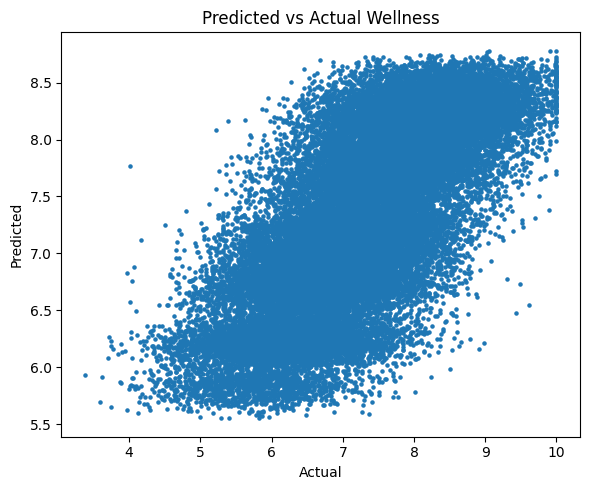

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(true_reg_list, pred_reg_list, s=5)
plt.title("Predicted vs Actual Wellness")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()


In [ ]:
import joblib

joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")

torch.save(model.state_dict(), "best_model.pth")

print("All files saved:")
print(" - scaler.pkl")
print(" - label_encoder.pkl")
print(" - best_model.pth")


All files saved:
 - scaler.pkl
 - label_encoder.pkl
 - best_model.pth


In [ ]:
print("num_cols =", num_cols)
print("len =", len(num_cols))

num_cols = ['day', 'age', 'heart_rate', 'bp_systolic', 'sleep_quality', 'symptom_score']
len = 6
